### 232745 Octavio Revetria

# Tarea 1 - Taller de Deep Learning

**Fecha de entrega: 19/10/2025**  
**Puntaje máximo: 15**

## Introducción

El objetivo de esta tarea es evaluar su conocimiento sobre Deep Learning aplicado a un caso de uso real. En particular, vamos a evaluar la performance de sus modelos en una tarea de clasificación de escenas.

**Dataset**

El dataset a ser utilizado es **Imagenette**, una versión simplificada de ImageNet que consiste de 10 clases. Pueden encontrar más información y descargarlo en el siguiente [link](https://pytorch.org/vision/main/generated/torchvision.datasets.Imagenette.html).

**Tarea**

Tienen total libertad sobre cómo implementar y resolver el problema así como las técnicas y herramientas que quieran usar. Recomendamos usar Colab por simplicidad, pero pueden implementarlo en sus máquinas si así lo prefieren. La única limitante es que esperamos que la entrega sea en formato .ipynb (Jupyter Notebook) **con las celdas ya ejecutadas**.

**Restricciones**

- No se permite utilizar models pre-entrenados (cada modelo debe ser implementado desde cero)
- Se requiere que utilicen al menos 2 técnicas de **regularización** (Dropout, BatchNorm, Data Augmentation, etc.)
- Se requiere realizar un **análisis de los datos**, que incluya el balanceo de clases y tomar decisiones en base al análisis realizado.
- Las decisiones tomadas sobre el preprocesamiento de las imágenes (transforms, augmentation, etc.) deben ser resultado de la exploración del dataset y estar propiamente justificadas (una sección de exploración en el notebook con comentarios es suficiente).

**Reporte**

En particular, les pedimos que reporten: accuracy, precision, recall y f1.
También se espera poder observar la evolución del modelo (en los datos de train y validación) a medida que se entrena (logs, gráficas, etc).

**Evidencia de Experimentos**

Además, deben presentar evidencia de correr experimentos usando [Weights & Biases (wandb)](https://wandb.ai/). Esto incluye:
- Registros detallados de los experimentos.
- Gráficas y logs de entrenamiento.
- Comparaciones entre diferentes configuraciones de modelos.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import numpy as np
import torch
import random
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import copy
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
from torchvision import transforms
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from Utils import train_w_early_stopping

c:\Users\Octav\miniconda3\envs\taller_dl\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\Octav\miniconda3\envs\taller_dl\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `A

In [2]:
train_dataset = datasets.Imagenette(
    root="./data", 
    download=True, 
)

## 1 Exploración del set de datos

Ver como vienen las imagenes, tamaños, colores y formato

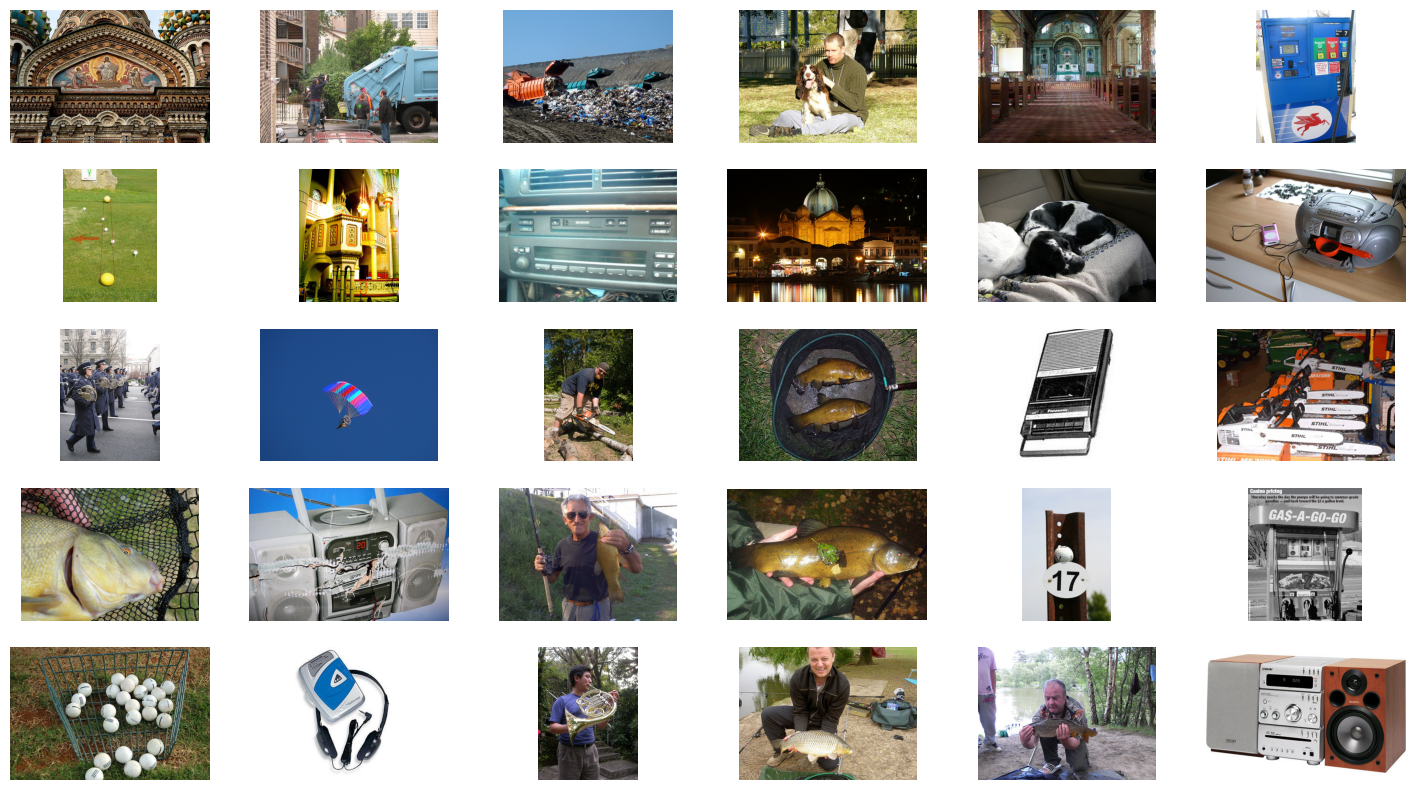

In [3]:
filas = 5
columnas = 6
_, ejes = plt.subplots(filas, columnas, figsize=(18, 10)) 
ejes_flat = ejes.flatten()
samples_indices = random.sample(range(len(train_dataset)), 30)

for i, i_eje in zip(samples_indices, range(30)):
    image, _ = train_dataset[i]
    plt.imshow(image)

    ax = ejes_flat[i_eje]
    ax.imshow(image)
    ax.axis("off")

### Primer muestreo
En nuestro primer muestreo, queda en evidencia que los tamaños varian. Por lo tanto, se realiza un muestreo completo del dataset de train. Para investigar; *tamaños*, *escala de colores* y *distribución de las clases*.

In [4]:
stats = []

for img, label in tqdm(train_dataset, desc="Leyendo imágenes"):
    stats.append({
        "class": train_dataset.classes[label][0],
        "width": img.width,
        "height": img.height,
        "mode": img.mode,
        "channels": len(img.getbands())
    })

df = pd.DataFrame(stats)

print(f"Total imágenes recolectadas: {len(df)}")
print("\n---- Conteo por clase ----")
print(df["class"].value_counts())
print("\n---- Conteo por modo de color ----")
print(df["mode"].value_counts())
print("\n---- Tamaños más comunes (width x height) ----")
print(df[["width","height"]].value_counts().head())


Leyendo imágenes: 100%|██████████| 9469/9469 [00:21<00:00, 433.98it/s]

Total imágenes recolectadas: 9469

---- Conteo por clase ----
class
cassette player     993
tench               963
garbage truck       961
parachute           960
French horn         956
English springer    955
golf ball           951
church              941
gas pump            931
chain saw           858
Name: count, dtype: int64

---- Conteo por modo de color ----
mode
RGB    9469
Name: count, dtype: int64

---- Tamaños más comunes (width x height) ----
width  height
500    375       2174
       333        818
375    500        717
333    500        309
500    334        207
Name: count, dtype: int64


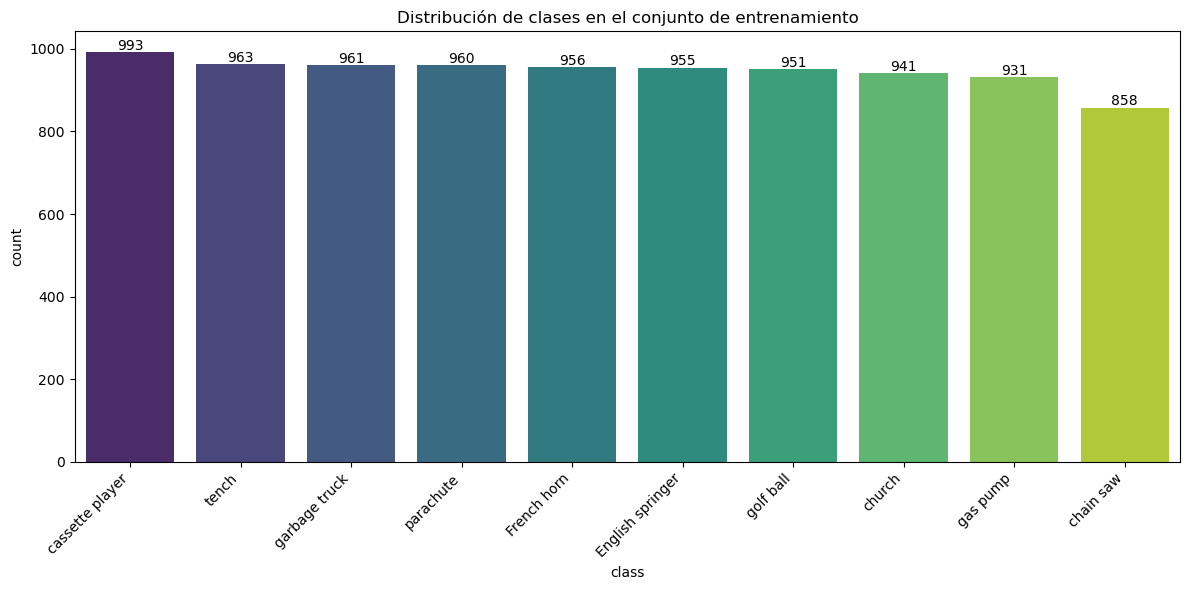

In [5]:
class_counts = df["class"].value_counts().reset_index()
class_counts.columns = ["class", "count"]

plt.figure(figsize=(12,6))
sns.barplot(data=class_counts, x="class", y="count", hue="class", palette="viridis", legend=False)

plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xticks(rotation=45, ha="right")

for i, row in class_counts.iterrows():
    plt.text(i, row["count"] + 5, str(row["count"]), ha="center")

plt.tight_layout()
plt.show()

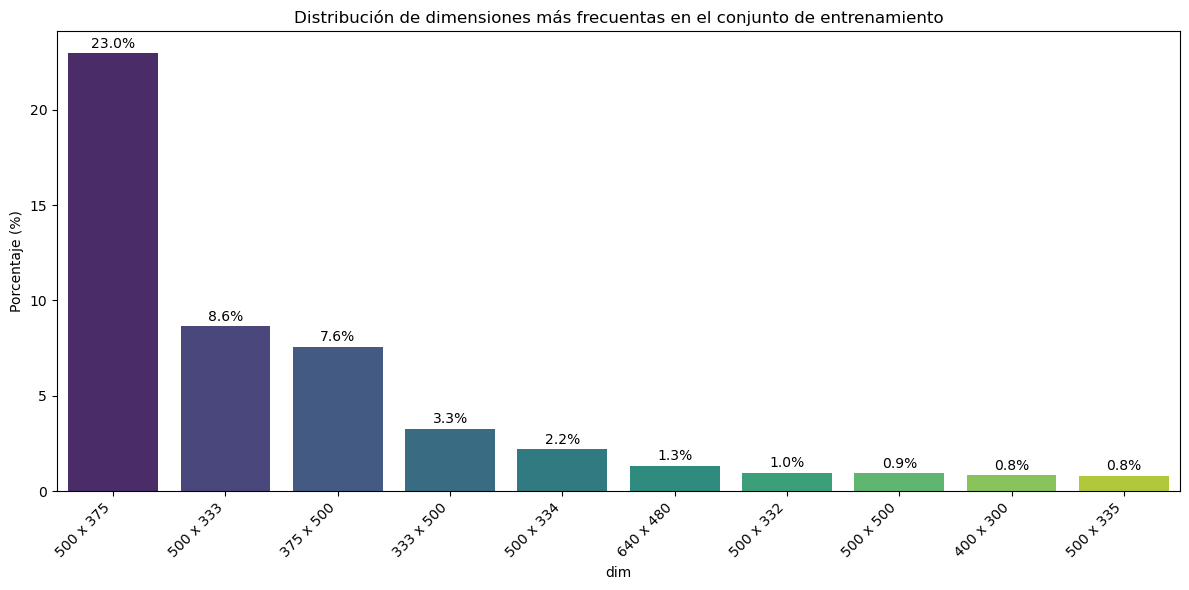

In [ ]:
dim_counts = df[["width","height"]].value_counts().reset_index()
dim_counts.columns = ["width", "height", "count"]
dim_counts["dim"] = dim_counts["width"].astype(str) + " x " + dim_counts["height"].astype(str)
dim_counts["dist"] = dim_counts["count"] / len(train_dataset) * 100
summary_dim_counts = dim_counts.sort_values(by="dist", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=summary_dim_counts, x="dim", y="dist", hue="dim", palette="viridis", legend=False)

plt.title("Distribución de dimensiones más frecuentes en el conjunto de entrenamiento")
plt.xticks(rotation=45, ha="right")

for i, row in summary_dim_counts.iterrows():
    plt.text(i, row["dist"] + 0.3, f"{row['dist']:.1f}%", ha="center")

plt.ylabel("Porcentaje (%)")
plt.tight_layout()
plt.show()

### Observaciones
Luego de **explorar** el dataset de train, se observa que:
- Existe desbalanceo de clases
- Las imagenes estan todas en color
- Varían en tamaño
- Hay imagenes en formato horizontal y vertical

## 2 Preprocesamiento de las imágenes
Para esta parte del proyecto, en base a lo aprendido en la exploración del conjunto de imágenes. Se decide como proceder y se evalua que técnicas utilizar.

Podemos concluir que la mayoría de las imagenes, se encuentran por encima de 160 pixeles de alto y ancho. Y que las dimensiones varian bastante, como se ve en el gráfico de la parte anterior.
Al cargarlas con la variante size "160px" de Imagenette, solo se asegura que el lado más corto de cada imagen sea 160 px, manteniendo su proporción original. 

Como el modelo requiere entradas cuadradas y uniformes, aplicamos un Resize(184) seguido de CenterCrop(160). Descartamos los bordes que por lo general aportan menos información.
El valor 184 del resize surge de la razón estandar de validación en ImageNet (relación 0.875 entre recorte y redimensionamiento), permitiendo mantener el encuadre central sin deformar la imagen. 
Nuestra transformación inicial por lo tanto incluye, normalización de 0 a 1, conversión a tensor, un resize de a 184 pixeles y un center crop de 160 pixeles.

In [14]:
transform_preprocesado = transforms.Compose([
    transforms.Resize(184),
    transforms.CenterCrop(160),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root="./data", 
    split="train", 
    size="160px",
    download=True, 
    transform=transform_preprocesado
)

val_dataset = datasets.Imagenette(
    root="./data", 
    split="val", 
    size="160px",
    download=True, 
    transform=transform_preprocesado
)

In [15]:
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True
)

### Data Augmentation
Para mejor aun la capacidad del modelo. Se decide probar distintas técnicas de Data Augmentation.
Las cuales serán probadas de una en una, para esto, se implementan 2 modelos.
- Una CNN simple de 2 capas convolucionales
- Una CNN de 3 capas convolucionales y batch normalization

A su vez, se utiliza early stopping en base a f1 en validación. Para evitar modelos complejos que memoricen.

In [16]:
class CNN_Simple(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Simple, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2) 
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x.view(x.size(0), -1))
        return x

In [17]:
class CNN_3C_BN(nn.Module):
    def __init__(self, num_classes):
        super(CNN_3C_BN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2) 
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128 * 1 * 1, 64)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)         
        x = x.view(x.size(0), -1)          
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Usando dispositivo: {device}")

num_classes = len(train_data.classes)
model = CNN_Simple(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs=30
patience=3

Usando dispositivo: cpu


In [19]:
model_1 = train_w_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Epoch 1/30 - Train Loss: 2.1590
Epoch 1/30 - Val Loss: 2.1009 - Val Acc: 0.2257 - Val F1 (w): 0.1932
New best F1: 0.1932 (model saved)
Epoch 2/30 - Train Loss: 2.0451
Epoch 2/30 - Val Loss: 2.0087 - Val Acc: 0.2820 - Val F1 (w): 0.2401
New best F1: 0.2401 (model saved)
Epoch 3/30 - Train Loss: 1.9480
Epoch 3/30 - Val Loss: 1.9246 - Val Acc: 0.3225 - Val F1 (w): 0.2850
New best F1: 0.2850 (model saved)
Epoch 4/30 - Train Loss: 1.8632
Epoch 4/30 - Val Loss: 1.8705 - Val Acc: 0.3521 - Val F1 (w): 0.3342
New best F1: 0.3342 (model saved)
Epoch 5/30 - Train Loss: 1.7908
Epoch 5/30 - Val Loss: 1.7771 - Val Acc: 0.3811 - Val F1 (w): 0.3677
New best F1: 0.3677 (model saved)
Epoch 6/30 - Train Loss: 1.7263
Epoch 6/30 - Val Loss: 1.7454 - Val Acc: 0.3842 - Val F1 (w): 0.3734
New best F1: 0.3734 (model saved)
Epoch 7/30 - Train Loss: 1.6737
Epoch 7/30 - Val Loss: 1.6774 - Val Acc: 0.4247 - Val F1 (w): 0.4037
New best F1: 0.4037 (model saved)
Epoch 8/30 - Train Loss: 1.6242
Epoch 8/30 - Val Loss: 

In [20]:
model = CNN_3C_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_2 = train_w_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Epoch 1/30 - Train Loss: 1.7545
Epoch 1/30 - Val Loss: 1.4795 - Val Acc: 0.4841 - Val F1 (w): 0.4643
New best F1: 0.4643 (model saved)
Epoch 2/30 - Train Loss: 1.3606
Epoch 2/30 - Val Loss: 1.3530 - Val Acc: 0.5587 - Val F1 (w): 0.5555
New best F1: 0.5555 (model saved)
Epoch 3/30 - Train Loss: 1.2596
Epoch 3/30 - Val Loss: 1.3647 - Val Acc: 0.5562 - Val F1 (w): 0.5330
 No improvement for 1 epoch(s)
Epoch 4/30 - Train Loss: 1.1626
Epoch 4/30 - Val Loss: 1.2771 - Val Acc: 0.5880 - Val F1 (w): 0.5821
New best F1: 0.5821 (model saved)
Epoch 5/30 - Train Loss: 1.1079
Epoch 5/30 - Val Loss: 1.0843 - Val Acc: 0.6502 - Val F1 (w): 0.6482
New best F1: 0.6482 (model saved)
Epoch 6/30 - Train Loss: 1.0538
Epoch 6/30 - Val Loss: 1.0615 - Val Acc: 0.6563 - Val F1 (w): 0.6504
New best F1: 0.6504 (model saved)
Epoch 7/30 - Train Loss: 1.0252
Epoch 7/30 - Val Loss: 1.3147 - Val Acc: 0.5722 - Val F1 (w): 0.5653
 No improvement for 1 epoch(s)
Epoch 8/30 - Train Loss: 0.9768
Epoch 8/30 - Val Loss: 1.0783

### Observación Modelos
Luego de un primer entrenamiento con los datos preprocesados levemente. Podemos ver que el segundo modelo, clasifica mejor que el primero.
Para este modelo, tiene mas capas convolucionales, mas canales finales y utiliza batch normalization.

La idea de usar *Batch Normalization* surge porque no contamos con un gran volumen de imágenes por clase. 
BN aporta estabilidad en las activaciones, evita ajustes demasiado grandes y agrega una regularización al introducir un ruido controlado durante el entrenamiento, lo que nos ayuda a generalizar mejor.

Para la prueba de técnicas de Data Augmentation, se continua evaluando pero solo con el segundo modelo.

### Evaluación con Horizontal Flip

In [21]:
transform_data_augmentation = transforms.Compose([
    transforms.Resize(184),
    transforms.CenterCrop(160),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root="./data", 
    split="train", 
    size="160px",
    download=True, 
    transform=transform_data_augmentation
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)

In [22]:
model = CNN_3C_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_2 = train_w_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Epoch 1/30 - Train Loss: 1.7887
Epoch 1/30 - Val Loss: 1.6143 - Val Acc: 0.4543 - Val F1 (w): 0.4229
New best F1: 0.4229 (model saved)
Epoch 2/30 - Train Loss: 1.4141
Epoch 2/30 - Val Loss: 1.4181 - Val Acc: 0.5302 - Val F1 (w): 0.5196
New best F1: 0.5196 (model saved)
Epoch 3/30 - Train Loss: 1.2752
Epoch 3/30 - Val Loss: 1.3063 - Val Acc: 0.5694 - Val F1 (w): 0.5649
New best F1: 0.5649 (model saved)
Epoch 4/30 - Train Loss: 1.2010
Epoch 4/30 - Val Loss: 1.2864 - Val Acc: 0.5610 - Val F1 (w): 0.5673
New best F1: 0.5673 (model saved)
Epoch 5/30 - Train Loss: 1.1364
Epoch 5/30 - Val Loss: 1.2140 - Val Acc: 0.6031 - Val F1 (w): 0.5939
New best F1: 0.5939 (model saved)
Epoch 6/30 - Train Loss: 1.0815
Epoch 6/30 - Val Loss: 1.1315 - Val Acc: 0.6191 - Val F1 (w): 0.5921
 No improvement for 1 epoch(s)
Epoch 7/30 - Train Loss: 1.0225
Epoch 7/30 - Val Loss: 1.1683 - Val Acc: 0.6150 - Val F1 (w): 0.5963
New best F1: 0.5963 (model saved)
Epoch 8/30 - Train Loss: 0.9692
Epoch 8/30 - Val Loss: 1.0

#### Observación
Se ven mejoras, así que se incorpora el horizontal flip a la transformación.

### Evaluación de RRC

In [23]:
transform_data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(160, scale=(0.6, 1.0), ratio=(0.75, 1.33)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root="./data", 
    split="train", 
    size="160px",
    download=True, 
    transform=transform_data_augmentation
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)

In [24]:
model = CNN_3C_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_2 = train_w_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Epoch 1/30 - Train Loss: 1.7798
Epoch 1/30 - Val Loss: 1.5051 - Val Acc: 0.5159 - Val F1 (w): 0.4942
New best F1: 0.4942 (model saved)
Epoch 2/30 - Train Loss: 1.4548
Epoch 2/30 - Val Loss: 1.3828 - Val Acc: 0.5552 - Val F1 (w): 0.5405
New best F1: 0.5405 (model saved)
Epoch 3/30 - Train Loss: 1.3381
Epoch 3/30 - Val Loss: 1.3486 - Val Acc: 0.5279 - Val F1 (w): 0.5117
 No improvement for 1 epoch(s)
Epoch 4/30 - Train Loss: 1.2524
Epoch 4/30 - Val Loss: 1.3595 - Val Acc: 0.5381 - Val F1 (w): 0.5294
 No improvement for 2 epoch(s)
Epoch 5/30 - Train Loss: 1.1873
Epoch 5/30 - Val Loss: 1.5521 - Val Acc: 0.4800 - Val F1 (w): 0.4667
 No improvement for 3 epoch(s)
Early stopping triggered at epoch 5
Best model loaded (best F1 = 0.5405)


### Observaciones
No se ven mejoras, se continua sin RRC.

### Evaluación Color Jitter

In [27]:
transform_data_augmentation = transforms.Compose([
    transforms.Resize(184),
    transforms.CenterCrop(160),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root="./data", 
    split="train", 
    size="160px",
    download=True, 
    transform=transform_data_augmentation
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)

In [28]:
model = CNN_3C_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model_2 = train_w_early_stopping(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=num_epochs,
    patience=patience,
    device=device
)

Epoch 1/30 - Train Loss: 1.7918
Epoch 1/30 - Val Loss: 1.6041 - Val Acc: 0.4561 - Val F1 (w): 0.4401
New best F1: 0.4401 (model saved)
Epoch 2/30 - Train Loss: 1.4297
Epoch 2/30 - Val Loss: 1.3519 - Val Acc: 0.5633 - Val F1 (w): 0.5385
New best F1: 0.5385 (model saved)
Epoch 3/30 - Train Loss: 1.3178
Epoch 3/30 - Val Loss: 1.4463 - Val Acc: 0.5256 - Val F1 (w): 0.5137
 No improvement for 1 epoch(s)
Epoch 4/30 - Train Loss: 1.2343
Epoch 4/30 - Val Loss: 1.2974 - Val Acc: 0.5682 - Val F1 (w): 0.5595
New best F1: 0.5595 (model saved)
Epoch 5/30 - Train Loss: 1.1704
Epoch 5/30 - Val Loss: 1.2182 - Val Acc: 0.6031 - Val F1 (w): 0.5863
New best F1: 0.5863 (model saved)
Epoch 6/30 - Train Loss: 1.1216
Epoch 6/30 - Val Loss: 1.3455 - Val Acc: 0.5531 - Val F1 (w): 0.5350
 No improvement for 1 epoch(s)
Epoch 7/30 - Train Loss: 1.0497
Epoch 7/30 - Val Loss: 1.2732 - Val Acc: 0.5890 - Val F1 (w): 0.5682
 No improvement for 2 epoch(s)
Epoch 8/30 - Train Loss: 1.0200
Epoch 8/30 - Val Loss: 1.0851 - 

### Observaciones
Se observan mejoras con Color Jitter. Por lo tanto, se agrega al preprocesado.

Con las técnicas de data augmentation definidas. Se marca como finalizada la etapa de preprocesado de datos.

### 3 Experimentación de modelos con Weights and Biases.

In [30]:
transform_data_augmentation_final = transforms.Compose([
    transforms.Resize(184),
    transforms.CenterCrop(160),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.Imagenette(
    root="./data", 
    split="train", 
    size="160px",
    download=True, 
    transform=transform_data_augmentation_final
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True
)

In [31]:
run = wandb.init(
    entity="octarevetria-universidad-ort-uruguay",
    project="imagenette-cnn-experiments",
    config={
        "learning_rate": 1e-3,
        "architecture": "CNN_3C_BN",
        "dataset": "Imagenette",
        "epochs": 30,
        "batch_size": 64,
        "optimizer": "Adam",
    },
)

model = CNN_3C_BN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

model = train_w_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=wandb.config.epochs,
    patience=5,
    device=device,
    wandb_run=run
)

run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Epoch 1/30 - Train Loss: 1.7806
Epoch 1/30 - Val Loss: 1.5996 - Val Acc: 0.4420 - Val F1 (w): 0.4178
New best F1: 0.4178 (model saved)
Epoch 2/30 - Train Loss: 1.4331
Epoch 2/30 - Val Loss: 1.4803 - Val Acc: 0.4764 - Val F1 (w): 0.4630
New best F1: 0.4630 (model saved)
Epoch 3/30 - Train Loss: 1.3253
Epoch 3/30 - Val Loss: 1.5253 - Val Acc: 0.4764 - Val F1 (w): 0.4749
New best F1: 0.4749 (model saved)
Epoch 4/30 - Train Loss: 1.2267
Epoch 4/30 - Val Loss: 1.1731 - Val Acc: 0.6204 - Val F1 (w): 0.6186
New best F1: 0.6186 (model saved)
Epoch 5/30 - Train Loss: 1.1397
Epoch 5/30 - Val Loss: 1.2355 - Val Acc: 0.5898 - Val F1 (w): 0.5866
 No improvement for 1 epoch(s)
Epoch 6/30 - Train Loss: 1.0859
Epoch 6/30 - Val Loss: 1.2020 - Val Acc: 0.6102 - Val F1 (w): 0.6013
 No improvement for 2 epoch(s)
Epoch 7/30 - Train Loss: 1.0581
Epoch 7/30 - Val Loss: 1.0813 - Val Acc: 0.6423 - Val F1 (w): 0.6387
New best F1: 0.6387 (model saved)
Epoch 8/30 - Train Loss: 1.0022
Epoch 8/30 - Val Loss: 1.1854

epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
train_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▂▂▅▄▅▆▄▄▆▆▅▆▇▆▇▆▆█▇▆▇▇█▇▇▇▇█
val_f1,▁▂▂▅▅▅▆▅▄▆▆▅▆▇▆▇▆▆█▇▆▇▇█▇▇█▇█
val_loss,█▇▇▄▅▅▄▄▅▃▄▄▃▃▄▂▃▃▁▂▄▂▂▁▂▂▂▂▁
epoch,29
train_loss,0.67341
val_acc,0.73427
val_f1,0.73065
val_loss,0.82774


### Información obtenida de WandB

#### **Métrica F1 para Validación**
![f1 para Validación](\charts\chart1.png)

#### **Training Loss**
![Loss para training](\charts\chart3.png)


### 4 Conclusiones

A lo largo del proyecto se comprobó que preparar correctamente las imágenes y elegir bien la arquitectura del modelo tiene un impacto directo en los resultados. Trabajar con un tamaño de 160×160 px fue suficiente para este dataset y permitió entrenar más rápido, mientras que centrar el recorte en la zona más relevante de la imagen ayudó a mejorar la clasificación.

El modelo CNN_3C_BN, con una capa adicional respecto al modelo simple y usando Batch Normalization, resultó más estable y logró generalizar mejor a nuevas imágenes. También se vio que aplicar data augmentation como horizontalflip y color jitter fue importante para evitar el sobreajuste.

Además, el uso de Weights and Biases permitió seguir la evolución del modelo en tiempo real y comparar fácilmente diferentes experimentos, facilitando la búsqueda de la mejor configuración.